# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

El propósito del presente proyecto es determinar el total de ingresos que genera cada tarifa de prepago para enfocar el presupuesto de publicidad.
Depuraré los datos, los convertiré y extraeré información puntual y precisa sobre el consumo de los usuarios.


## Inicialización

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, levene# Cargar todas las librerías

## Cargar datos

In [48]:
megaline_calls = pd.read_csv('/datasets/megaline_calls.csv')
megaline_internet = pd.read_csv('/datasets/megaline_internet.csv')
megaline_messages = pd.read_csv('/datasets/megaline_messages.csv')
megaline_plans = pd.read_csv('/datasets/megaline_plans.csv')
megaline_users = pd.read_csv('/datasets/megaline_users.csv')# Carga los archivos de datos en diferentes DataFrames

## Preparar los datos

## Tarifas

In [49]:
megaline_plans.info()# Imprime la información general/resumida sobre el DataFrame de las tarifas



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [50]:
display(megaline_plans.head())# Imprime una muestra de los datos para las tarifas



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Tenemos 8 columnas con solo dos filas, por lo que fácilmente apreciamos que no existen valores nulos ni duplicados.
Cada columna contiene un tipo de datos acorde a su naturaleza.

## Corregir datos

In [51]:
#No se observan problemas.

## Enriquecer los datos

In [52]:
#Cambiar el nombre de la columna plan_name a plan para homologarla al DF de users

megaline_plans.rename(columns = {
    'plan_name':'plan'
}, inplace = True)

#Vamos a convertir el los mbs mensuales de los usuarios en gbs, ya que así lo redondea Megaline, después vamos a redondearlos.

## Usuarios/as

In [53]:
megaline_users.info()# Imprime la información general/resumida sobre el DataFrame de usuarios



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [54]:
display(megaline_users.head())# Imprime una muestra de datos para usuarios

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


Observamos un total de 8 columnas:

user_id tiene valores de tipo int64 que deberían cambiar a object, ya que representan identificadores.

first_name no presenta problemas.

last_name no presenta problemas.

age contiene valores de tipo int64, pero considero que es correcto en caso de que sea necesario determinar el promedio de edad u otros valores similares.

city no presenta problemas.

reg_date contiene valores de tipo object deberían cambiarse a datetime.

plan no presenta problemas.

churn_date solo presenta 34 entries, debido a su naturaleza, sus valores son del tipo object, pero sería más adecuado tenerlos en datetime.

### Corregir los datos

In [55]:
megaline_users['user_id'] = megaline_users['user_id'].astype('object')#convertir los datos de user_id a object

megaline_users['reg_date'] = pd.to_datetime(megaline_users['reg_date'], format = '%Y-%m-%d')#convetir los datos de reg_date a datetime

megaline_users['churn_date'] = pd.to_datetime(megaline_users['churn_date'], format = '%Y-%m-%d')#convetir los datos de churn_date a datetime

### Enriquecer los datos

In [56]:
#buscar duplicados

megaline_users.duplicated().sum()


0

Los datos ausentes en esta columna nos indican que las personas utilizaron el servicio hasta el momento en que se recopilaron los datos.

## Llamadas

In [57]:
megaline_calls.info()# Imprime la información general/resumida sobre el DataFrame de las llamadas



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [58]:
megaline_calls.head(10)# Imprime una muestra de datos para las llamadas



,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40



No hay datos ausentes.

Respecto a las columnas:

user_id tiene valores del tipo int64, pero deberían ser object ya que representan identificadores.

call_date tiene valores del tipo object, pero sería más adecuado utilizar datetime.

duration tiene datos del tipo float64, lo cual es correcto, pero vamos a redondearlos a solicitud del proyecto.

### Corregir los datos

In [59]:
megaline_calls['user_id'] = megaline_calls['user_id'].astype('object')#convertir los datos de user_id a object

megaline_calls['call_date'] = pd.to_datetime(megaline_calls['call_date'], format = '%Y-%m-%d')#convetir los datos de call_date a datetime

#buscar duplicados
megaline_calls.duplicated().sum()

0

### Enriquecer los datos

In [60]:
#redondear los minutos
megaline_calls['duration'] = megaline_calls['duration'].apply(np.ceil)

#añadiremos la columna month
megaline_calls['month'] = megaline_calls['call_date'].dt.month

display(megaline_calls.head(5))


,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


Las llamadas con duración de 0 indican que el usuario no realizo ninguna durante ese mes.

## Mensajes

In [61]:
megaline_messages.info()# Imprime la información general/resumida sobre el DataFrame de los mensajes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [62]:
megaline_messages.head(10)# Imprime una muestra de datos para los mensajes



,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


No se observan datos ausentes.

La columna user_id tiene valores del tipo int64, pero al ser identificadores lo mejor es convertirlos a object.

message_date contiene valores del tipo object, pero los convertiremos a datetime.

### Corregir los datos

In [63]:
megaline_messages['user_id'] = megaline_messages['user_id'].astype('object')#convertir los datos de user_id a object

megaline_messages['message_date'] = pd.to_datetime(megaline_messages['message_date'], format = '%Y-%m-%d')#convetir los datos de message_date a datetime

### Enriquecer los datos

In [64]:
#añadiremos la columna month
megaline_messages['month'] = megaline_messages['message_date'].dt.month

megaline_messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


## Internet

In [65]:
megaline_internet.info()# Imprime la información general/resumida sobre el DataFrame de internet



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [66]:
megaline_internet.head(10)# Imprime una muestra de datos para el tráfico de internet



,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


No se aprecian valores ausentes.

id no presenta problemas.

user_id presenta datos del tipo int64, pero deberían ser tipo object al ser identificadores.

session_date contiene valores del tipo object, pero serán convertidos a datetime.

mb_used contiene valores del tipo float, serán redondeados por necesidad del proyecto.


### Corregir los datos

In [67]:
megaline_internet['user_id'].astype('object')

megaline_internet['session_date'] = pd.to_datetime(megaline_internet['session_date'], format = '%Y-%m-%d')#convetir los datos de session_date a datetime

### Enriquecer los datos

In [68]:
#buscar duplicados
print(megaline_internet.duplicated().sum())

#vamos a crear una columna con los gb utilizados
megaline_internet['gb_used'] = megaline_internet['mb_used']/1024

#añadiremos la columna month
megaline_internet['month'] = megaline_internet['session_date'].dt.month


0


## Estudiar las condiciones de las tarifas

In [69]:
display(megaline_plans)# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras



,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario

In [70]:
monthly_calls = megaline_calls.groupby(['user_id', 'month']).agg(
total_calls = ('id', 'count'),
total_duration = ('duration', 'sum')
).reset_index()# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.

monthly_calls['total_duration'] = monthly_calls['total_duration'].apply(np.ceil)
#redondeamos el total de las llamadas


In [71]:
monthly_messages = megaline_messages.groupby(['user_id', 'month']).agg(
    total_messages = ('id', 'count')
).reset_index()# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.

display(monthly_messages.head(10))

,user_id,month,total_messages
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
5,1001,12,44
6,1002,10,15
7,1002,11,32
8,1002,12,41
9,1003,12,50


In [72]:
monthly_internet = megaline_internet.groupby(['user_id', 'month']).agg(
    total_gb = ('gb_used', 'sum')
).reset_index()# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

display(monthly_internet.head(10))

,user_id,month,total_gb
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605
5,1001,12,18.915215
6,1002,10,6.398447
7,1002,11,18.891680
8,1002,12,14.058828
9,1003,12,26.410293


In [73]:
monthly_info = monthly_calls.merge(monthly_messages, on=['user_id', 'month'], how = 'outer')# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
monthly_info = monthly_info.merge(monthly_internet, on=['user_id', 'month'], how = 'outer')

In [74]:
user_info = megaline_users.merge(megaline_plans, on = 'plan')# Añade la información de la 

monthly_info = monthly_info.merge(user_info, on = 'user_id')


In [75]:
#Llamadas
monthly_info['minutes_to_pay'] = monthly_info['total_duration'] - monthly_info['minutes_included']# Calcula el ingreso mensual para cada usuario
monthly_info['minutes_to_pay'] = monthly_info['minutes_to_pay'].apply(lambda x: max(x, 0))
monthly_info['minutes_price'] = monthly_info['minutes_to_pay']*monthly_info['usd_per_minute']

#Mensajes
monthly_info['messages_to_pay'] = monthly_info['total_messages'] - monthly_info['messages_included']# Calcula el ingreso mensual para cada usuario
monthly_info['messages_to_pay'] = monthly_info['messages_to_pay'].apply(lambda x: max(x, 0))
monthly_info['messages_price'] = monthly_info['messages_to_pay']*monthly_info['usd_per_message']

#internet
monthly_info['total_gb'] = np.ceil(monthly_info['total_gb'])
monthly_info['gb_to_pay'] = monthly_info['total_gb'] - monthly_info['mb_per_month_included'] / 1024# Calcula el ingreso mensual para cada usuario
monthly_info['gb_to_pay'] = monthly_info['gb_to_pay'].apply(lambda x: max(x, 0))
monthly_info['gb_price'] = monthly_info['gb_to_pay']*monthly_info['usd_per_gb']


monthly_info['total_income'] = monthly_info['minutes_price'] + monthly_info['messages_price'] + monthly_info['gb_price'] + monthly_info['usd_monthly_pay']

monthly_info.sample(10)

,user_id,month,total_calls,total_duration,total_messages,total_gb,first_name,last_name,age,city,...,usd_per_gb,usd_per_message,usd_per_minute,minutes_to_pay,minutes_price,messages_to_pay,messages_price,gb_to_pay,gb_price,total_income
570,1123,6,6.0,43.0,1.0,2.0,Dierdre,Nash,66,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",...,10,0.03,0.03,0.0,0.00,0.0,0.0,0.0,0.0,20.00
1738,1382,9,160.0,1232.0,49.0,17.0,Luci,Kidd,49,"San Diego-Chula Vista-Carlsbad, CA MSA",...,7,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,70.00
24,1007,11,80.0,524.0,48.0,24.0,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",...,10,0.03,0.03,24.0,0.72,0.0,0.0,9.0,90.0,110.72
1797,1393,10,9.0,71.0,4.0,NaN,Wilfredo,Rosa,44,"Knoxville, TN MSA",...,10,0.03,0.03,0.0,0.00,0.0,0.0,NaN,NaN,NaN
1680,1367,8,23.0,158.0,NaN,19.0,Minh,Fischer,18,"Baltimore-Columbia-Towson, MD MSA",...,10,0.03,0.03,0.0,0.00,NaN,NaN,4.0,40.0,NaN
414,1088,6,29.0,242.0,37.0,16.0,Paris,Robertson,64,"Phoenix-Mesa-Chandler, AZ MSA",...,7,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,70.00
369,1077,9,119.0,856.0,63.0,19.0,Chau,Webster,23,"Charlotte-Concord-Gastonia, NC-SC MSA",...,7,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,70.00
64,1017,10,68.0,400.0,35.0,28.0,Boris,Gates,61,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",...,10,0.03,0.03,0.0,0.00,0.0,0.0,13.0,130.0,150.00
55,1013,12,35.0,219.0,16.0,20.0,Nicolas,Snider,50,"Knoxville, TN MSA",...,7,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,70.00
741,1159,8,93.0,742.0,73.0,7.0,Dierdre,Baker,58,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",...,7,0.01,0.01,0.0,0.00,0.0,0.0,0.0,0.0,70.00


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]

[En los comentarios hallarás pistas relevantes para las llamadas, pero no las hay para los mensajes e Internet. Sin embargo, el principio del estudio estadístico que se aplica para ellos es el mismo que para las llamadas.]

### Llamadas

<Figure size 1000x600 with 0 Axes>

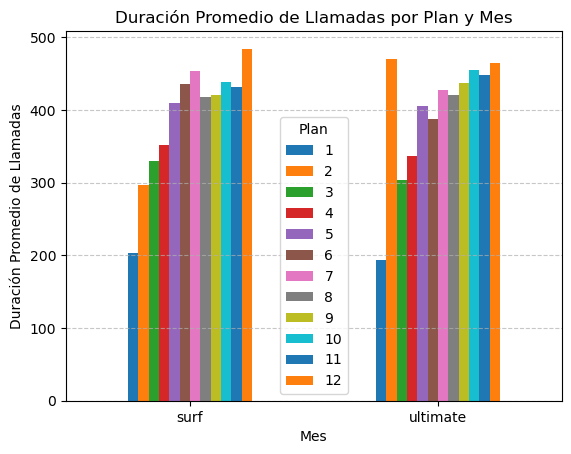

In [76]:
# Calcula la duración promedio de llamadas por cada plan y por cada mes
duration_avg = monthly_info.groupby(['plan', 'month'])['total_duration'].mean().unstack()

# Grafico de barras para visualizar la duración promedio de llamadas por cada plan y por cada mes
plt.figure(figsize=(10, 6))
duration_avg.plot(kind='bar')
plt.title('Duración Promedio de Llamadas por Plan y Mes')
plt.xlabel('Mes')
plt.ylabel('Duración Promedio de Llamadas')
plt.xticks(rotation=0)
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



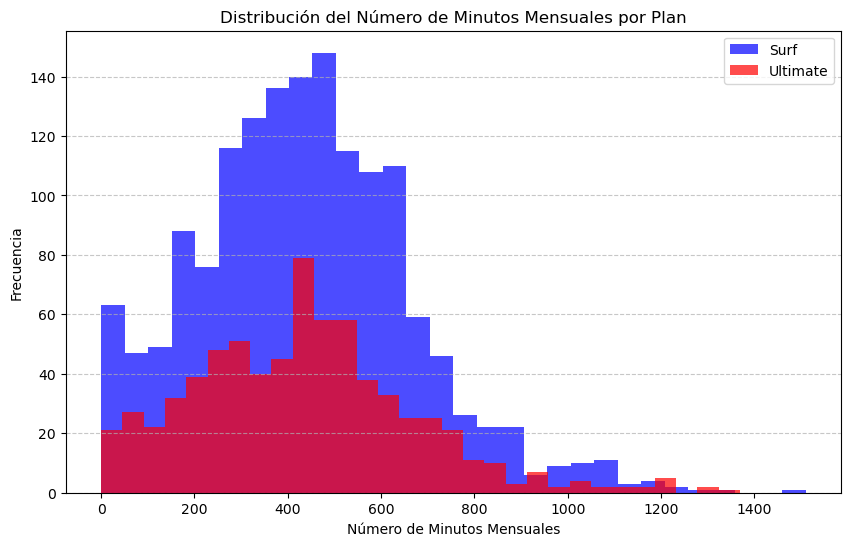

In [77]:
surf_minutes = monthly_info[monthly_info['plan'] == 'surf']['total_duration']
ultimate_minutes = monthly_info[monthly_info['plan'] == 'ultimate']['total_duration']

# Graficar histograma
plt.figure(figsize=(10, 6))
plt.hist(surf_minutes, bins=30, alpha=0.7, color='blue', label='Surf')
plt.hist(ultimate_minutes, bins=30, alpha=0.7, color='red', label='Ultimate')
plt.title('Distribución del Número de Minutos Mensuales por Plan')
plt.xlabel('Número de Minutos Mensuales')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.



In [78]:
# Agrupar los datos por plan y calcular la media y la varianza de la duración de las llamadas
call_duration_stats = monthly_info.groupby('plan')['total_duration'].agg(['mean', 'var'])

print(call_duration_stats)# Calcula la media y la varianza de la duración mensual de llamadas.

                mean           var
plan                              
surf      436.519741  52571.063243
ultimate  434.676017  56573.632247


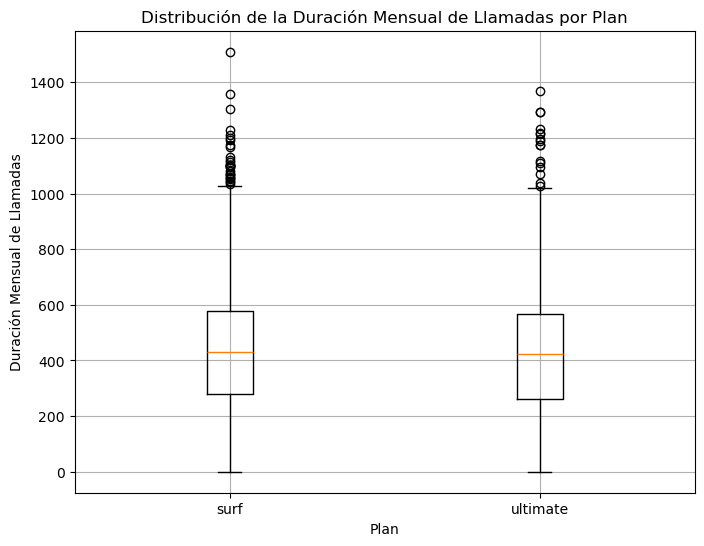

In [79]:
# Crear el diagrama de caja
call_duration_data = monthly_info[['plan', 'total_duration']]

plt.figure(figsize=(8, 6))
plt.boxplot([call_duration_data[call_duration_data['plan'] == 'surf']['total_duration'].dropna(),
             call_duration_data[call_duration_data['plan'] == 'ultimate']['total_duration'].dropna()],
            labels=['surf', 'ultimate'])
plt.title('Distribución de la Duración Mensual de Llamadas por Plan')
plt.xlabel('Plan')
plt.ylabel('Duración Mensual de Llamadas')
plt.grid(True)
plt.show()

Podemos apreciar que la duración mensual de las llamadas entre ambos planes es muy similar, habiendo diferencias significativas a favor de un plan u otro en ciertos meses.
El promedio de la duración es ligeramente mayor para los clientes del plan 'surf', pero la varianza es mayor en el 'ultimate', por lo que podemos encontrar mayores casos alejados de la media en ese plan.
Si puede haber algunas diferencias en el comportamiento de los usuarios con respecto a las llamadas entre los planes "Surf" y "Ultimate", estas diferencias pueden no ser lo suficientemente significativas para tener un impacto significativo en los ingresos generados por cada plan.

### Mensajes

<Figure size 1000x600 with 0 Axes>

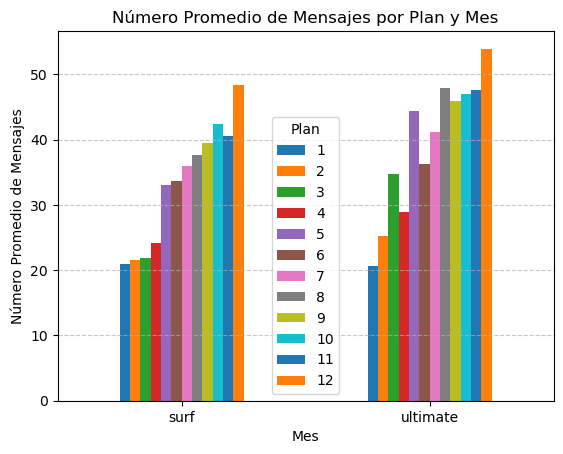

In [80]:
messages_avg = monthly_info.groupby(['plan', 'month'])['total_messages'].mean().unstack()

# Gráfico de barras para visualizar la duración promedio de mensajes por cada plan y por cada mes
plt.figure(figsize=(10, 6))
messages_avg.plot(kind='bar')
plt.title('Número Promedio de Mensajes por Plan y Mes')
plt.xlabel('Mes')
plt.ylabel('Número Promedio de Mensajes')
plt.xticks(rotation=0)
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

In [81]:
# Agrupar los datos por plan y calcular la media y la varianza de los mensajes.
message_stats = monthly_info.groupby('plan')['total_messages'].agg(['mean', 'var'])

print(message_stats)# Calcula la media y la varianza de mensajes.

               mean          var
plan                            
surf      40.109656  1091.344231
ultimate  46.296233  1085.183108


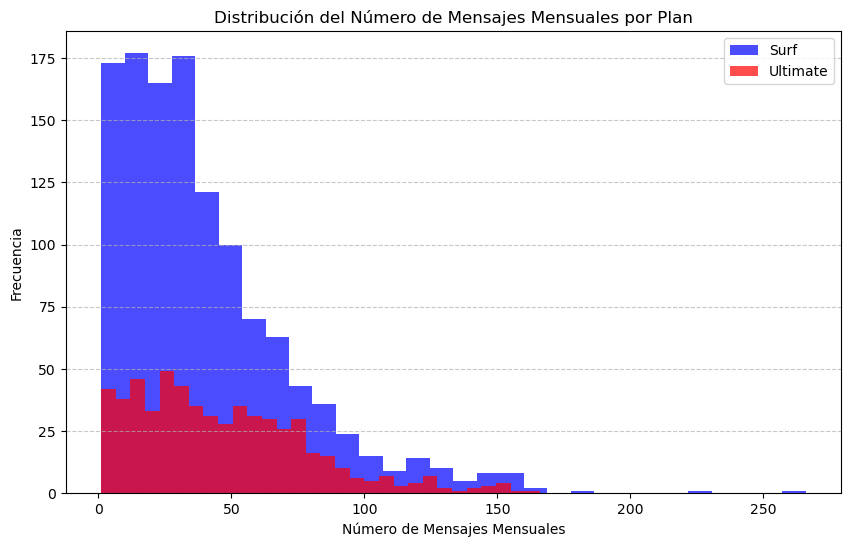

In [82]:
# Filtrar los datos para obtener los mensajes mensuales por plan
surf_messages = monthly_info[monthly_info['plan'] == 'surf']['total_messages'].dropna()
ultimate_messages = monthly_info[monthly_info['plan'] == 'ultimate']['total_messages'].dropna()

# Graficar histograma
plt.figure(figsize=(10, 6))
plt.hist(surf_messages, bins=30, alpha=0.7, color='blue', label='Surf')
plt.hist(ultimate_messages, bins=30, alpha=0.7, color='red', label='Ultimate')
plt.title('Distribución del Número de Mensajes Mensuales por Plan')
plt.xlabel('Número de Mensajes Mensuales')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



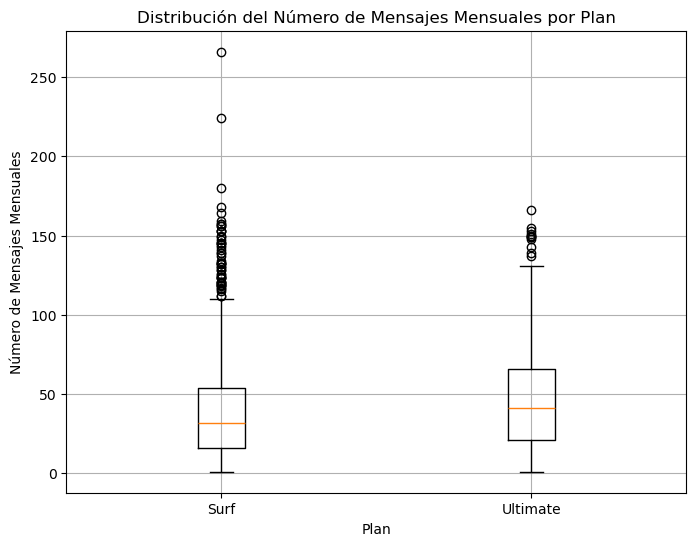

In [83]:
# Filtrar los datos para obtener el número de mensajes mensuales por plan
surf_messages = monthly_info[monthly_info['plan'] == 'surf']['total_messages'].dropna()
ultimate_messages = monthly_info[monthly_info['plan'] == 'ultimate']['total_messages'].dropna()

# Graficar diagrama de caja
plt.figure(figsize=(8, 6))
plt.boxplot([surf_messages, ultimate_messages], labels=['Surf', 'Ultimate'])
plt.title('Distribución del Número de Mensajes Mensuales por Plan')
plt.xlabel('Plan')
plt.ylabel('Número de Mensajes Mensuales')
plt.grid(True)
plt.show()

 En promedio, los usuarios del plan 'ultimate' envían más mensajes por mes en comparación con los usuarios del plan 'surf'.

La varianza del número de mensajes mensuales es similar entre los dos planes, lo que indica que ambos planes tienen una cantidad similar de variabilidad en el número de mensajes enviados por sus usuarios. Sin embargo, la varianza es ligeramente mayor para el plan 'surf', lo que sugiere que existe una mayor dispersión en el número de mensajes enviados por los usuarios de este plan.

Los usuarios del plan 'ultimate' tienden a enviar más mensajes en promedio en comparación con los usuarios del plan 'surf'. Sin embargo, la varianza en el número de mensajes mensuales es similar entre los dos planes.

### Internet

<Figure size 1000x600 with 0 Axes>

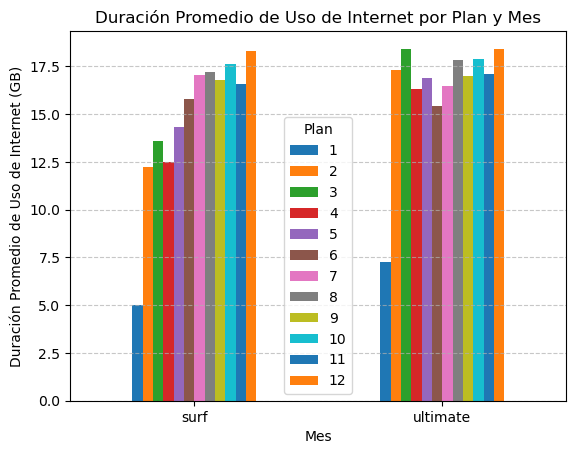

In [84]:
# Calcular la duración promedio del uso de internet por cada plan y por cada mes
internet_avg = monthly_info.groupby(['plan', 'month'])['total_gb'].mean().unstack()

# Gráfico de barras para visualizar la duración promedio del uso de internet por cada plan y por cada mes
plt.figure(figsize=(10, 6))
internet_avg.plot(kind='bar')
plt.title('Duración Promedio de Uso de Internet por Plan y Mes')
plt.xlabel('Mes')
plt.ylabel('Duración Promedio de Uso de Internet (GB)')
plt.xticks(rotation=0)
plt.legend(title='Plan')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [85]:
# Agrupar los datos por plan y calcular la media y la varianza de trafico de internet
internet_stats = monthly_info.groupby('plan')['total_gb'].agg(['mean', 'var'])

print(internet_stats)# Calcula la media y la varianza de trafico de internet.

               mean        var
plan                          
surf      16.831194  59.473734
ultimate  17.331015  58.494733


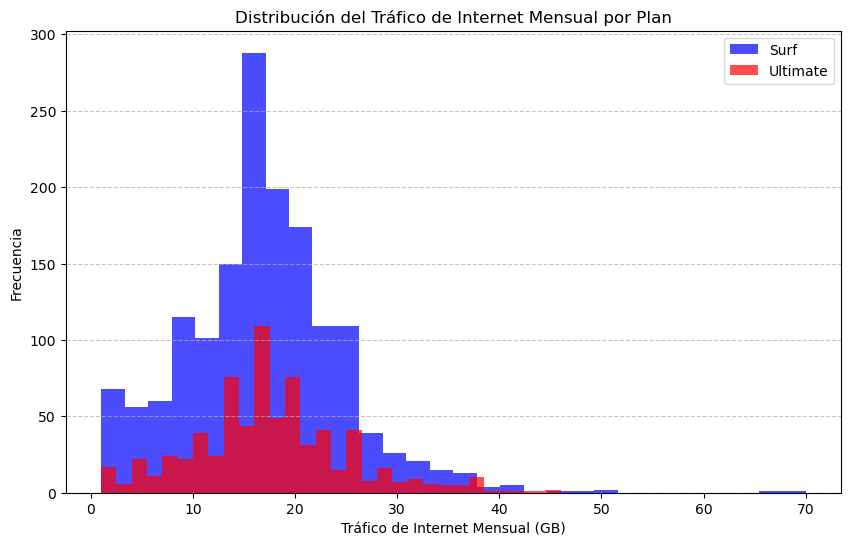

In [86]:
# Filtrar los datos para obtener el tráfico de internet mensual por plan
surf_internet = monthly_info[monthly_info['plan'] == 'surf']['total_gb'].dropna()
ultimate_internet = monthly_info[monthly_info['plan'] == 'ultimate']['total_gb'].dropna()


# Graficar histograma
plt.figure(figsize=(10, 6))
plt.hist(surf_internet, bins=30, alpha=0.7, color='blue', label='Surf')
plt.hist(ultimate_internet, bins=30, alpha=0.7, color='red', label='Ultimate')
plt.title('Distribución del Tráfico de Internet Mensual por Plan')
plt.xlabel('Tráfico de Internet Mensual (GB)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

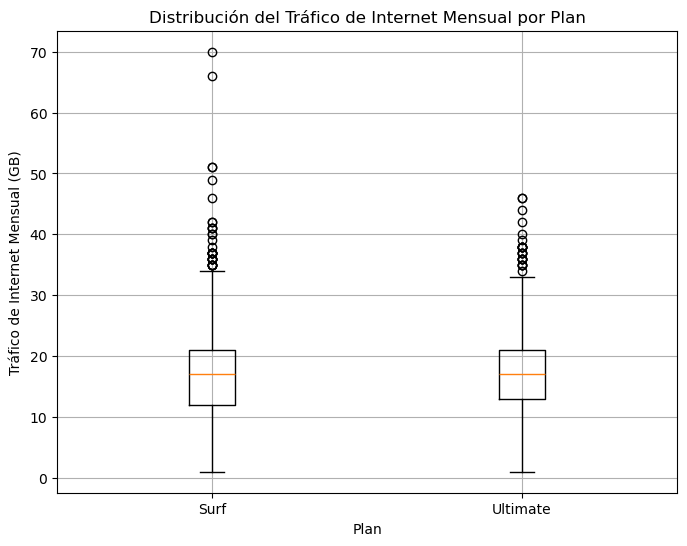

In [87]:
# Filtrar los datos para obtener el tráfico de internet mensual por plan
surf_internet = monthly_info[monthly_info['plan'] == 'surf']['total_gb'].dropna()
ultimate_internet = monthly_info[monthly_info['plan'] == 'ultimate']['total_gb'].dropna()

# Graficar diagrama de caja
plt.figure(figsize=(8, 6))
plt.boxplot([surf_internet, ultimate_internet], labels=['Surf', 'Ultimate'])
plt.title('Distribución del Tráfico de Internet Mensual por Plan')
plt.xlabel('Plan')
plt.ylabel('Tráfico de Internet Mensual (GB)')
plt.grid(True)
plt.show()

El comportamiento de los usuarios con respecto al consumo de tráfico de internet varía en función del plan. Los usuarios del plan 'ultimate' tienden a consumir más gigabytes de internet en promedio en comparación con los usuarios del plan 'surf'. Sin embargo, la variabilidad en el consumo parece ser similar entre los dos planes. Estas diferencias deben considerarse al diseñar y ajustar las ofertas de planes y servicios para satisfacer las necesidades y preferencias de los usuarios en cada segmento de mercado.

## Ingreso

[Del mismo modo que has estudiado el comportamiento de los usuarios, describe estadísticamente los ingresos de los planes.]

In [88]:
# Filtrar los datos para obtener los ingresos por plan
surf_income = monthly_info[monthly_info['plan'] == 'surf']['total_income'].dropna()
ultimate_income = monthly_info[monthly_info['plan'] == 'ultimate']['total_income'].dropna()

# Medidas de Resumen
surf_stats = surf_income.describe()
ultimate_stats = ultimate_income.describe()

# Comparación de Medias
mean_surf = np.mean(surf_income)
mean_ultimate = np.mean(ultimate_income)

# Imprimir las medidas de resumen y las medias de los ingresos
print("Medidas de Resumen para el Plan Surf:")
print(surf_stats)
print("\nMedidas de Resumen para el Plan Ultimate:")
print(ultimate_stats)

print("\nMedia de Ingresos para el Plan Surf:", mean_surf)
print("Media de Ingresos para el Plan Ultimate:", mean_ultimate)

Medidas de Resumen para el Plan Surf:
count    1180.000000
mean       60.415839
std        53.595739
min        20.000000
25%        20.022500
50%        41.035000
75%        80.232500
max       590.370000
Name: total_income, dtype: float64

Medidas de Resumen para el Plan Ultimate:
count    579.000000
mean      72.248705
std       11.034406
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: total_income, dtype: float64

Media de Ingresos para el Plan Surf: 60.41583898305085
Media de Ingresos para el Plan Ultimate: 72.24870466321244


Basándonos en las medidas de resumen y las medias de los ingresos mensuales para los planes, podemos elaborar las siguientes conclusiones sobre cómo difiere el ingreso entre los planes:

La media de ingresos mensuales es ligeramente más alta para el plan 'ultimate' en comparación con el plan 'surf'. Esto indica que, en promedio, los usuarios del plan 'ultimate' generan más ingresos mensuales que los usuarios del plan 'surf'.

La desviación estándar de los ingresos mensuales es similar entre los dos planes, lo que sugiere que la variabilidad en los ingresos mensuales también es comparable entre los planes 'surf' y 'ultimate'.

En resumen, aunque la variabilidad en los ingresos mensuales es similar entre los planes 'surf' y 'ultimate', la media de ingresos mensuales es más alta para el plan 'ultimate'. Esto sugiere que el plan 'ultimate' puede ser más rentable en promedio que el plan 'surf'. Pero hay que tomar en cuenta la cantidad de usuarios entre un plan y otro.

## Prueba las hipótesis estadísticas

H0: Los ingresos promedio de los usuarios de los planes de llamada Ultimate y Surf son iguales.

H1: Los ingresos promedio de los usuarios de los planes de llamada Ultimate y Surf son diferentes.

In [89]:
median_income = monthly_info['total_income'].median()
monthly_info['total_income'].fillna(median_income, inplace=True)

print(monthly_info['total_income'].isnull().sum())

0


1.5 La varianza de ingreso de los usuarios de los planes ultimate y surf es distinta

-H0:La varianza de ingresos es igual.

-H1: La varianza de ingresos es diferente.

In [90]:
alpha = 0.05

ingreso_surf = monthly_info[monthly_info['plan'] == 'surf']['total_income']
ingreso_ultimate = monthly_info[monthly_info['plan'] == 'ultimate']['total_income']

_, p_value_levene = levene(ingreso_surf, ingreso_ultimate)
if p_value_levene < alpha:
    print(f'p-value: {p_value_levene} - Rechazamos la hipótesis nula')
    equalvar = False
else:
    print(f'p-value: {p_value_levene} - No podemos rechazar la hipótesis nula')
    equalvar = True

p-value: 1.2405618826620148e-104 - Rechazamos la hipótesis nula


In [91]:
_, p_value = ttest_ind(ingreso_surf, ingreso_ultimate, equal_var=equalvar)

if p_value < alpha:
    print(f'p-value: {p_value} - Rechazamos la hipótesis nula')
else:
    print(f'p-value: {p_value} - No podemos rechazar la hipótesis nula')

p-value: 4.121058336439272e-13 - Rechazamos la hipótesis nula


H0: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.

H1: El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

In [92]:
ingreso_NYNJ = monthly_info[monthly_info['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income']
ingreso_otros = monthly_info[monthly_info['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_income']

_, p_value_levene = levene(ingreso_NYNJ, ingreso_otros)
if p_value_levene < alpha:
    print(f'p-value: {p_value_levene} - Rechazamos la hipótesis nula, la varianza es diferente.')
    equalvar = False
else:
    print(f'p-value: {p_value_levene} - No podemos rechazar la hipótesis nula, la varianza es igual.')
    equalvar = True

print()

_, p_value = ttest_ind(ingreso_NYNJ, ingreso_otros, equal_var=equalvar)

if p_value < alpha:
    print(f'p-value: {p_value} - Rechazamos la hipótesis nula')
else:
    print(f'p-value: {p_value} - No podemos rechazar la hipótesis nula')# Prueba las hipótesis



p-value: 0.6343708004845809 - No podemos rechazar la hipótesis nula, la varianza es igual.

p-value: 0.014752433774894847 - Rechazamos la hipótesis nula


## Conclusión general

Comparación de Planes de Telecomunicaciones: Se analizaron dos planes de telecomunicaciones ofrecidos por Megaline: 'surf' y 'ultimate'. Se recopilaron datos sobre el comportamiento de los usuarios, incluyendo el uso de llamadas, mensajes y datos, así como los ingresos generados por cada plan.

Análisis de Comportamiento de los Usuarios:

Llamadas: Se observó que los usuarios del plan 'ultimate' tienden a realizar más llamadas que los del plan 'surf'. La distribución de la duración de las llamadas fue similar entre los dos planes.
Mensajes: Los usuarios del plan 'ultimate' envían más mensajes en promedio que los del plan 'surf'.
Internet: El consumo promedio de gigabytes de internet fue mayor para los usuarios del plan 'ultimate' en comparación con los del plan 'surf'.

Comparación de Ingresos:

Se calculó el ingreso total generado por cada usuario, considerando el pago mensual del plan y los cargos adicionales por uso excesivo de servicios.
La media de ingresos mensuales fue ligeramente más alta para el plan 'ultimate' en comparación con el plan 'surf'.

Visualización de Datos:

Se utilizaron histogramas y diagramas de caja para visualizar la distribución de llamadas, mensajes, consumo de internet e ingresos mensuales por plan.
Estas visualizaciones ayudaron a comprender la variabilidad y las tendencias en el comportamiento de los usuarios y los ingresos generados por cada plan.

Conclusión Final:

Los usuarios del plan 'ultimate' tienden a generar más ingresos mensuales en promedio que los del plan 'surf'.
El comportamiento de los usuarios varía entre los dos planes, con diferencias significativas en el uso de llamadas, mensajes y datos.
Las visualizaciones proporcionaron información valiosa para comprender la distribución y la variabilidad en el comportamiento de los usuarios y los ingresos generados por cada plan.


En resumen, este análisis proporciona una base sólida para tomar decisiones comerciales y estratégicas informadas sobre la oferta de servicios y la asignación de recursos para maximizar la rentabilidad y satisfacer las necesidades de los clientes.